In [1]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from semantics.pipeline import Pipeline
from semantics.train import Trainer, TrainerConfig
import semantics.vision as sv

# Configuration parameters
batch_size = 128
dim = 128
img_size = 32
modulation = True
num_channels = 3
channel_mean = 0.0
channel_std = 0.1
channel_snr = None
channel_avg_power = None

encoder_cfg = {
    'in_ch': num_channels,
    'k': dim,
    'reparameterize': False
}

decoder_cfg = {
    'out_ch': num_channels,
    'k': dim,
    'reparameterize': True
}

channel_config = {
    'mean': channel_mean,
    'std': channel_std,
    'snr': channel_snr,
    'avg_power': channel_avg_power
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = sv.VSCCEncoder(**encoder_cfg).to(device)
decoder = sv.VSCCDecoder(**decoder_cfg).to(device)
channel = sv.AWGNChannel(**channel_config).to(device)
pipeline = Pipeline(encoder, channel, decoder).to(device)

# Data
transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])
train_ds = datasets.CIFAR10("./data", train=True,  download=True, transform=transform)
val_ds   = datasets.CIFAR10("./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Optimizer and Loss
optimizer = Adam(pipeline.parameters(), lr=3e-4)
criterion = torch.nn.L1Loss()

# Simple metrics
metrics = {
        "psnr": sv.PSNRMetric(),
        'ssim': sv.SSIMMetric(data_range=1.0, size_average=True, channel=3)
    }

# Train
cfg = TrainerConfig(
    num_epochs=20,
    learning_rate=3e-4,
    use_amp=True,          # turn on mixed precision
    amp_dtype="auto",      # auto-select bf16/fp16
    grad_accum_steps=1,    # increase if batches are small
    clip_grad_norm=1.0,    # optional safety
    compile_model=False,   # set True if PyTorch 2.x and stable graph
)
trainer = Trainer(
    pipeline=pipeline,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=criterion,
    config=cfg,
    metrics=metrics,
)
trainer.train()

/home/jmadden2/anaconda3/envs/semantics/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[epoch 000] epoch=0.0000 train_loss=0.1191 val_loss=0.0891 val_psnr=18.4826 val_ssim=0.5637


[epoch 001] epoch=1.0000 train_loss=0.0775 val_loss=0.0643 val_psnr=21.1711 val_ssim=0.6832


[epoch 002] epoch=2.0000 train_loss=0.0599 val_loss=0.0559 val_psnr=22.2811 val_ssim=0.7496


[epoch 003] epoch=3.0000 train_loss=0.0539 val_loss=0.0518 val_psnr=22.9505 val_ssim=0.7768


[epoch 004] epoch=4.0000 train_loss=0.0495 val_loss=0.0468 val_psnr=23.7392 val_ssim=0.7891


[epoch 005] epoch=5.0000 train_loss=0.0455 val_loss=0.0442 val_psnr=24.2207 val_ssim=0.8030


[epoch 006] epoch=6.0000 train_loss=0.0434 val_loss=0.0425 val_psnr=24.4952 val_ssim=0.8096


[epoch 007] epoch=7.0000 train_loss=0.0418 val_loss=0.0408 val_psnr=24.7762 val_ssim=0.8190


[epoch 008] epoch=8.0000 train_loss=0.0405 val_loss=0.0401 val_psnr=24.9745 val_ssim=0.8294


[epoch 009] epoch=9.0000 train_loss=0.0392 val_loss=0.0406 val_psnr=24.9561 val_ssim=0.8395


[epoch 010] epoch=10.0000 train_loss=0.0383 val_loss=0.0378 val_psnr=25.4509 val_ssim=0.8401


[epoch 011] epoch=11.0000 train_loss=0.0370 val_loss=0.0368 val_psnr=25.6890 val_ssim=0.8506


[epoch 012] epoch=12.0000 train_loss=0.0360 val_loss=0.0360 val_psnr=25.8963 val_ssim=0.8547


[epoch 013] epoch=13.0000 train_loss=0.0350 val_loss=0.0347 val_psnr=26.1740 val_ssim=0.8636


[epoch 014] epoch=14.0000 train_loss=0.0343 val_loss=0.0342 val_psnr=26.3253 val_ssim=0.8690


[epoch 015] epoch=15.0000 train_loss=0.0334 val_loss=0.0338 val_psnr=26.4968 val_ssim=0.8735


[epoch 016] epoch=16.0000 train_loss=0.0327 val_loss=0.0323 val_psnr=26.7916 val_ssim=0.8771


[epoch 017] epoch=17.0000 train_loss=0.0320 val_loss=0.0316 val_psnr=26.9902 val_ssim=0.8798


[epoch 018] epoch=18.0000 train_loss=0.0311 val_loss=0.0310 val_psnr=27.1725 val_ssim=0.8869


[epoch 019] epoch=19.0000 train_loss=0.0305 val_loss=0.0304 val_psnr=27.3389 val_ssim=0.8886


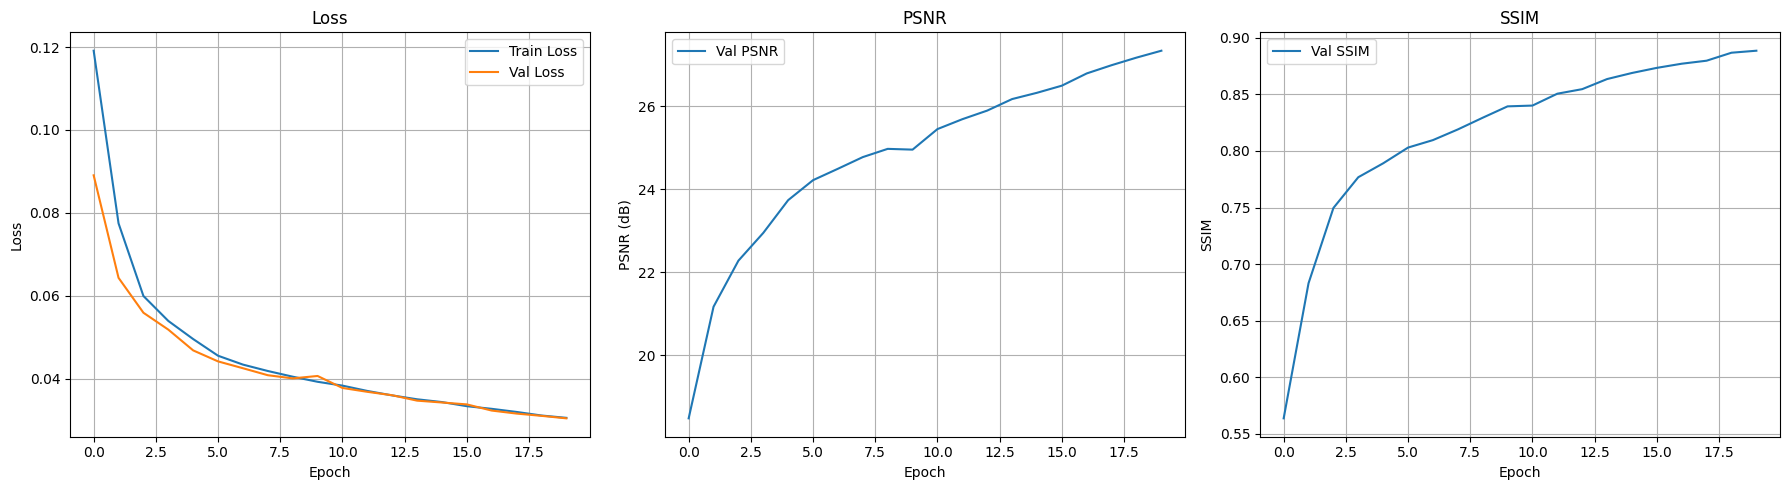

In [2]:
import matplotlib.pyplot as plt

history = trainer.history

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train & Val Loss
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# PSNR
axes[1].plot(history["val_psnr"], label="Val PSNR")
axes[1].set_title("PSNR")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("PSNR (dB)")
axes[1].legend()
axes[1].grid()

# SSIM
axes[2].plot(history["val_ssim"], label="Val SSIM")
axes[2].set_title("SSIM")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("SSIM")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

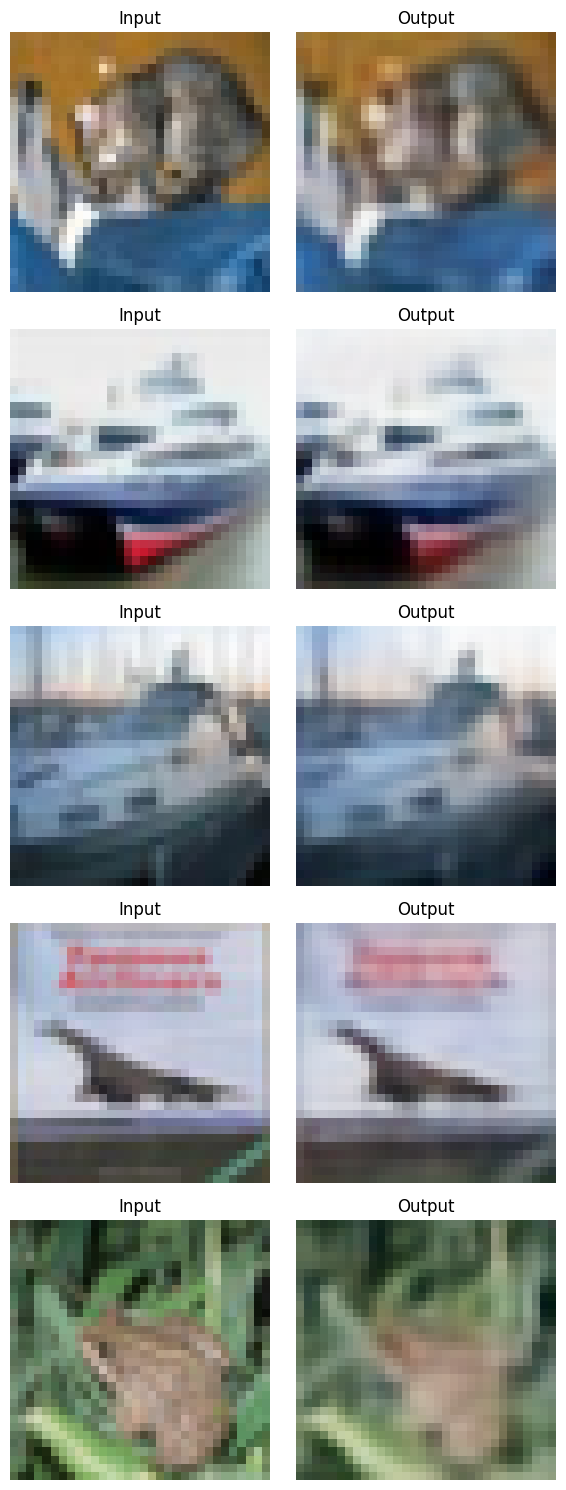

In [3]:
import numpy as np

# Get a batch of images from the validation loader
images, _ = next(iter(val_loader))
images = images.to(device)

# Pass images through the pipeline
ckpt_path = "checkpoints/best.pt"
trainer.load(ckpt_path)
pipeline = trainer.pipeline
with torch.no_grad():
    outputs, _ = pipeline(images)

# Move tensors to CPU and convert to numpy
inputs_np = images.cpu().numpy().clip(0, 1)
outputs_np = outputs.cpu().numpy().clip(0, 1)

# Visualize first 5 images: input and output side by side
fig, axes = plt.subplots(5, 2, figsize=(6, 15))
for i in range(5):
    # Input image
    axes[i, 0].imshow(np.transpose(inputs_np[i], (1, 2, 0)))
    axes[i, 0].set_title("Input")
    axes[i, 0].axis("off")
    # Output image
    axes[i, 1].imshow(np.transpose(outputs_np[i], (1, 2, 0)))
    axes[i, 1].set_title("Output")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()